### 11761 - Image and Video Analysis - Crowd Counting
Universitat de les Illes Balears - Intelligent Systems

Yolanda, Amelia 

Alsatouf, Abdulrahman

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bin.crowd_counting import crowd_counting
from bin.utilities import crop_image, merge_images, windowing, euclidean_distance


In [2]:
labels_path = "data/labels.csv"
labels = pd.read_csv(labels_path)
labels.head()

object    x    y           image
0  Person  148  766  1660284000.jpg
1  Person  105  769  1660284000.jpg
2  Person  621  719  1660287600.jpg
3  Person  865  746  1660287600.jpg
4  Person  929  608  1660287600.jpg

In [3]:
images = labels["image"].unique()
#images = np.array(file)
images

array(['1660284000.jpg', '1660287600.jpg', '1660291200.jpg',
       '1660294800.jpg', '1660298400.jpg', '1660302000.jpg',
       '1660305600.jpg', '1660309200.jpg', '1660316400.jpg',
       '1660320000.jpg'], dtype=object)

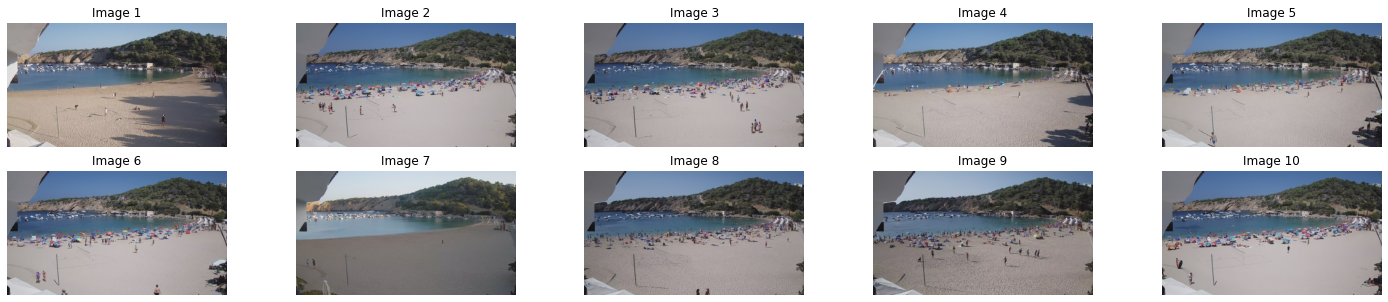

In [4]:
# Visualize input images

images_path = 'Data/'
input_images = [cv2.imread(os.path.join(images_path, image)) for image in os.listdir(images_path) if image.endswith('jpg')]

fig, axes = plt.subplots(2, 5, figsize=(25,5))
axes = axes.flatten()

for count, img in enumerate(input_images):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[count].set_title(f'Image {count+1}')
    axes[count].imshow(image)
    axes[count].axis('off')
plt.show()


Function for Validation

In [5]:
def count_persons(contours, image, remaining_image, labels, tol):
    try:
        # Store the estimated number of persons
        num_estimated_persons = len(contours)

        # Define a region of interest
        region_of_interest = image.copy()

        # Create an array to store the coordinates of the bounding boxes
        bboxes = np.zeros([len(contours), 4])
        # Draw bounding boxes
        for i in range(len(contours)):
            x, y, w, h = cv2.boundingRect(contours[i])
            # Draw bounding boxes
            cv2.rectangle(region_of_interest, (x, y), (x + w, y + h), (255, 0, 0), 2)
            # Draw centroid of bounding box
            cv2.circle(region_of_interest, (x + w // 2, y + h // 2), 5, (255, 0, 0), -1)
            # Compute coordinates for extended bounding boxes
            tolx, toly = int(tol * w), int(tol * h)
            # Draw extended bounding boxes
            cv2.rectangle(region_of_interest, (x - tolx, y - toly), (x + w + tolx, y + h + toly), (255, 0, 0), 2)
            # Store coordinates of each bounding box
            bboxes[i, :] = [x - tolx, y - toly + 410, w + tolx, h + toly]

        # Count the number of persons based on the euclidean distance
        num_persons = 0
        hit = np.zeros(len(bboxes))
        for j in range(len(labels)):
            for k in range(len(bboxes)):
                x, y, w, h = bboxes[k, :]
                cent = (x + w // 2, y + h // 2)
                dist = euclidean_distance(cent, labels[j, :])
                if dist <= 100 and hit[k] == 0:
                    num_persons += 1
                    hit[k] = 1
                    # Draw centroid of bounding box with a hit
                    cv2.circle(region_of_interest, tuple(map(int, (cent[0], cent[1] - 410))), 7, (255, 255, 0), -1)

        # Merge the region of interest with the remaining image
        output_image = merge_images(remaining_image, region_of_interest)

        return num_estimated_persons, num_persons, output_image

    except Exception as e:
        print(f"Error: {str(e)}")
        return None

Crowd Counting

In [6]:
def crowd_counting(image_path, images, labels, region_of_interest, tol, plotting=False):
    try:
        estimated_persons = []
        detected_persons = []

        for image_name in images:
            # Read the image
            image = cv2.imread(image_path + image_name)

            # Extract the coordinates of each annotated person
            annotated_persons = labels[labels['image'] == image_name][['x', 'y']].values

            # Convert BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Crop the image to avoid capturing background noise
            cropped_image, remaining_image = crop_image(image_rgb, region_of_interest)

            # Convert the bgr image to grayscale
            grayscale_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

            # Apply windowing
            windowed_image = windowing(grayscale_image, 120, 109)

            # Apply Otsu's thresholding
            _, binary_image = cv2.threshold(windowed_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Apply morphological opening
            kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_opening)

            # Apply morphological closing
            kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel_closing)

            # Find Sobel edges
            sobel_x = cv2.Sobel(closed_image, cv2.CV_64F, 1, 0, ksize=3)
            sobel_y = cv2.Sobel(closed_image, cv2.CV_64F, 0, 1, ksize=3)
            sobel_edges = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

            # Threshold the Sobel edges
            _, binary_edges = cv2.threshold(sobel_edges, 50, 255, cv2.THRESH_BINARY)

            # Find contours based on the Sobel edges
            contours, _ = cv2.findContours(binary_edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Create a mask for the contours to keep
            keep_mask = np.zeros_like(binary_edges.astype(np.uint8))

            # Filter contours based on area and aspect ratio
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                aspect_ratio = cv2.boundingRect(contour)[2] / cv2.boundingRect(contour)[3]  # Width / height
                if 200 < area < 800 and 0.4 < aspect_ratio < 4:
                    filtered_contours.append(contour)
                    cv2.drawContours(keep_mask, [contour], -1, 255, thickness=cv2.FILLED)

            # Count the number of persons on the image
            count_estimated, count_detected, output_image = count_persons(filtered_contours,
                                                                          cropped_image,
                                                                          remaining_image,
                                                                          annotated_persons,
                                                                          tol)

            # Store the number of estimated and detected persons
            estimated_persons.append(count_estimated)
            detected_persons.append(count_detected)

            if plotting:
                fig = plt.figure(figsize=(12, 10))
                # Plot the resulting image
                plt.imshow(output_image)
                # Extract coordinates of annotated persons for plotting
                x, y = zip(*annotated_persons)
                # Plot points on the image
                plt.scatter(x, y, color='blue', marker='o', s=10)
                # Turn off axis labels
                plt.axis('off')
                # Save the figure
                #plt.savefig('../results/output_image_' + image_name, dpi=500)
                # Display the image
                plt.show()

        return np.array(estimated_persons), np.array(detected_persons)

    except Exception as e:
        print(f"Error: {str(e)}")
        return None

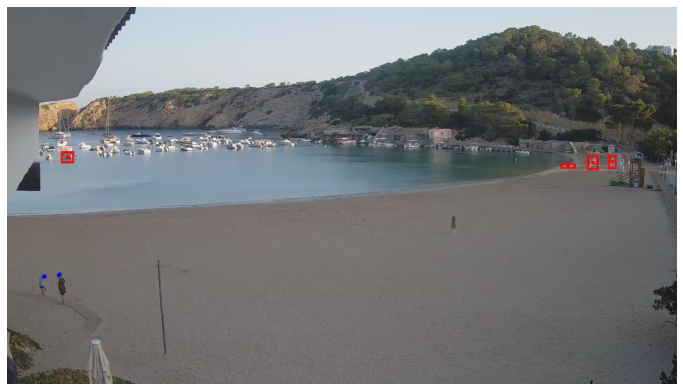

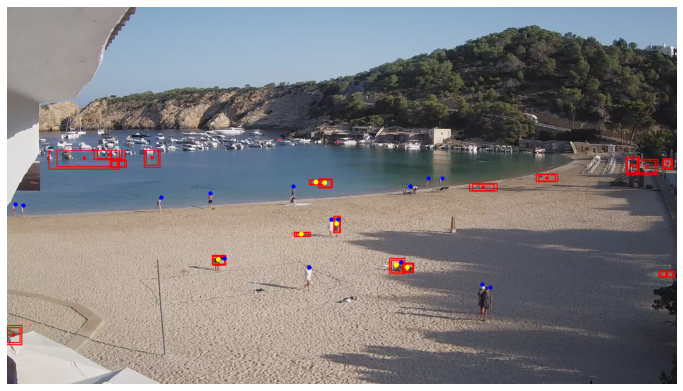

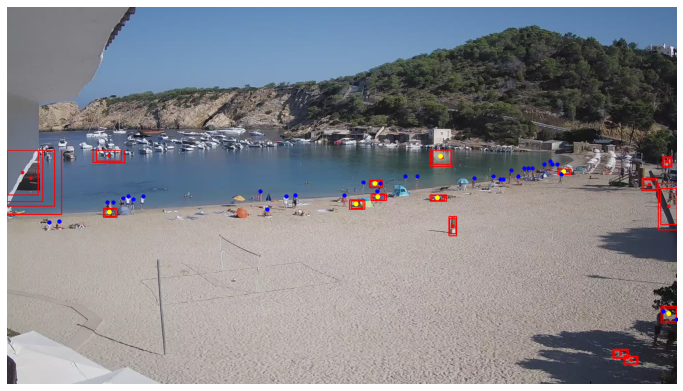

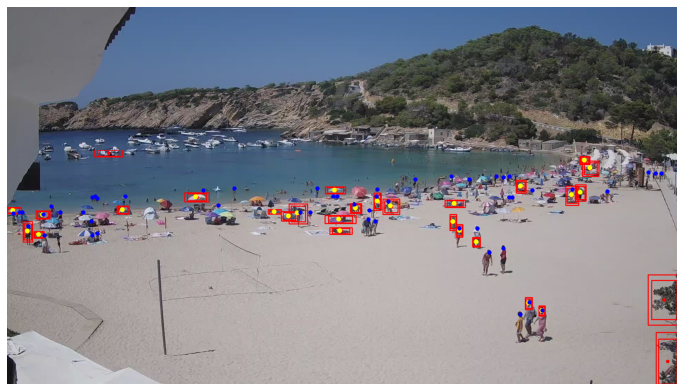

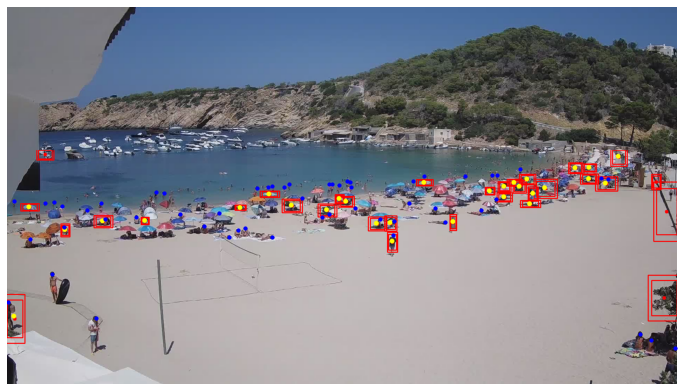

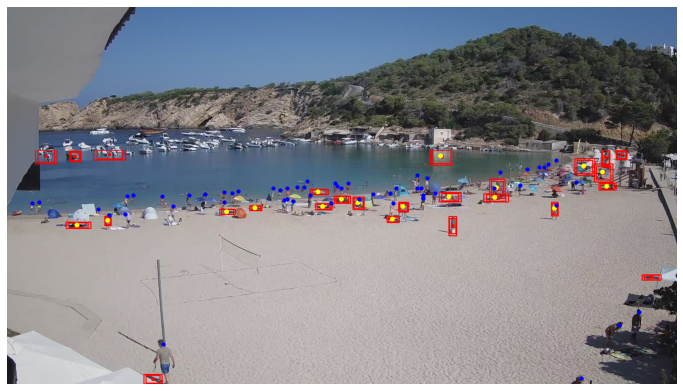

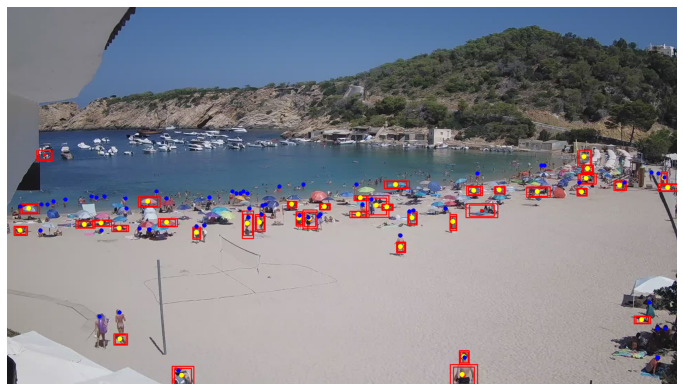

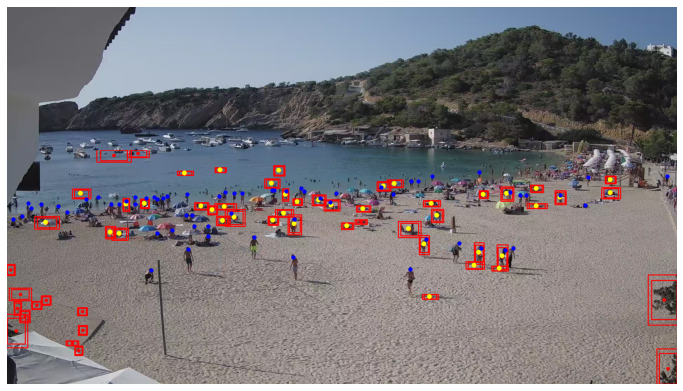

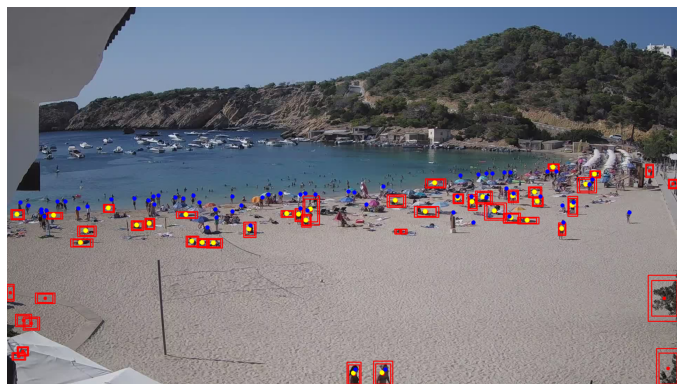

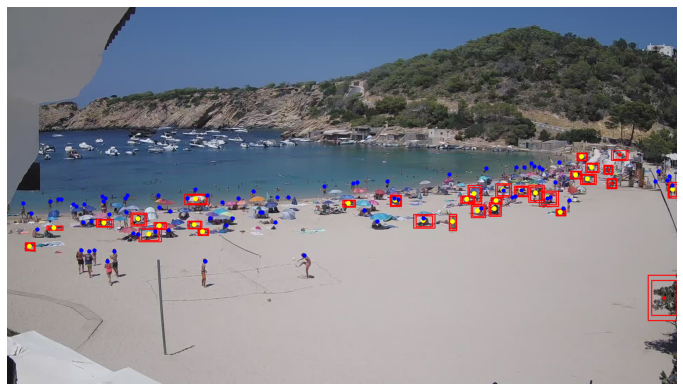

In [7]:
# Apply algorithm to dataset
image_path = 'data/'
images = np.array(['1660284000.jpg', '1660287600.jpg', '1660291200.jpg', '1660309200.jpg', '1660302000.jpg',
                   '1660294800.jpg', '1660298400.jpg', '1660320000.jpg', '1660316400.jpg', '1660305600.jpg'])
annotated_persons = np.genfromtxt(fname=image_path + 'labels_aggregated.csv', delimiter=',')
annotated_persons = annotated_persons[1:11, 1][::-1]
region_of_interest = [0, 1080 - 670, 1920, 670]
tol = 0.15 # Tolerance rate for expanding bounding boxes
estimated_persons, detected_persons = crowd_counting(image_path=image_path,
                                                     images=images,
                                                     labels=labels,
                                                     region_of_interest=region_of_interest,
                                                     tol=tol,
                                                     plotting=True)

In [8]:
# PERFORMANCE EVALUATION
print(f'Number of annotated persons per image: {annotated_persons}')
print(f'Estimated number of persons per image (predicted positive): {estimated_persons}')
print(f'Mean Squared Error: {(1 / annotated_persons.shape[0]) * ((sum(annotated_persons - estimated_persons)) ** 2)}')
print('')
print(f'Detected number of persons per image (true positive): {detected_persons}')
print(f'Average accuracy per image: {round(np.mean(detected_persons / annotated_persons) * 100, 2)}%')
print('')
print(f'Correlation Coefficient (annotated vs. detected persons): '
      f'{round(np.corrcoef(annotated_persons, detected_persons)[0, 1], 4)}')


Number of annotated persons per image: [ 2. 15. 34. 52. 56. 56. 58. 64. 64. 79.]
Estimated number of persons per image (predicted positive): [ 4 18 17 29 34 26 39 58 46 32]
Mean Squared Error: 3132.9

Detected number of persons per image (true positive): [ 0  7  8 26 30 18 37 42 35 28]
Average accuracy per image: 42.55%

Correlation Coefficient (annotated vs. detected persons): 0.8571
